# 1) Base Model Creation

## Load Data

In [1]:
from PIL import Image

import numpy as np
import os
import pandas as pd

import torchvision
from torchvision import transforms

import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
import torch.nn as nn
'''
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, accuracy_score, f1_score
'''
import matplotlib.pyplot as plt
print(torch.__version__) 

2.4.0+cu121


## Functions for Metrics:

In [40]:
def print_stats_percentage_train_test(algo, y_test, y_pred):
    #Converting inputs to cpu tensors because cuda ones can't be converted to numpy:
    
    print("Algorithm: ", algo)
    
    print('Accuracy: %.2f' % accuracy_score(y_test,   y_pred) )
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('F1-measure: %.3f' % f1_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    
    print("confusion matrix")
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print(confmat)

In [39]:
def print_conf_matrix(y_test, y_pred, names):
    cm = confusion_matrix(y_test, y_pred)
    display = ConfusionMatrixDisplay(cm, display_labels=names)
    fig, ax = plt.subplots(figsize=(15,15))
    display.plot(ax=ax)

## Get Images:

In [2]:
img_dir_men = "Dataset/Train/Male_reduzida"
img_dir_women = "Dataset/Train/Female_reduzida"

In [3]:
filenames_men = [os.path.join(img_dir_men, file) for file in os.listdir(img_dir_men)[:10000]]
filenames_women = [os.path.join(img_dir_women, file) for file in os.listdir(img_dir_women)[:10000]]
filenames = filenames_men + filenames_women

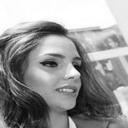

In [13]:
grey_images = [Image.open(file).convert('L').resize((128, 128)) for file in filenames]
grey_images[15060]

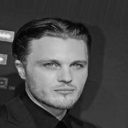

In [14]:
grey_images[5]

In [16]:
transform = transforms.Compose([transforms.PILToTensor()])
images = [transform(img) for img in grey_images]

images = torch.stack(images, dim=0)

## Create Labels

In [17]:
labels_men = [0 for _ in filenames_men]
labels_women = [1 for _ in filenames_women]
labels = labels_men + labels_women
labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

## Combine images and labels into a cohesive dataset

In [12]:
print(images.size())

torch.Size([39999, 1, 218, 178])


In [13]:
print(labels.size())

torch.Size([39999, 1])


In [18]:
train_ds = TensorDataset(images.float(), labels)

In [19]:
batch_size   = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True)

## Model

In [20]:
DL_model = nn.Sequential(
    nn.Linear(128*128, 1024), 
    nn.Sigmoid(),
    nn.Linear(1024, 128),
    nn.Sigmoid(),
    nn.Linear(128, 4),
    nn.Sigmoid(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)

In [21]:
learning_rate = 1e-2
n_epochs = 400

model_fn = DL_model
loss_fn = nn.BCELoss()

## Loop

Epoch:  0
Learning Rate:  [0.01]
Loss:  0.6817458868026733
Accuracy:  0.6098
Epoch:  1
Learning Rate:  [0.0098]
Loss:  0.6769521832466125
Accuracy:  0.64595
Epoch:  2
Learning Rate:  [0.009604]
Loss:  0.6738579273223877
Accuracy:  0.67165
Epoch:  3
Learning Rate:  [0.009411919999999999]
Loss:  0.6661021709442139
Accuracy:  0.6927
Epoch:  4
Learning Rate:  [0.009223681599999999]
Loss:  0.6620779037475586
Accuracy:  0.7041
Epoch:  5
Learning Rate:  [0.009039207967999998]
Loss:  0.6038683652877808
Accuracy:  0.72015
Epoch:  6
Learning Rate:  [0.008858423808639998]
Loss:  0.6064109206199646
Accuracy:  0.7294
Epoch:  7
Learning Rate:  [0.008681255332467197]
Loss:  0.6375075578689575
Accuracy:  0.74165
Epoch:  8
Learning Rate:  [0.008507630225817853]
Loss:  0.5651421546936035
Accuracy:  0.7515
Epoch:  9
Learning Rate:  [0.008337477621301496]
Loss:  0.6419334411621094
Accuracy:  0.75595
Epoch:  10
Learning Rate:  [0.008170728068875466]
Loss:  0.5554793477058411
Accuracy:  0.75875
Epoch:  11
L

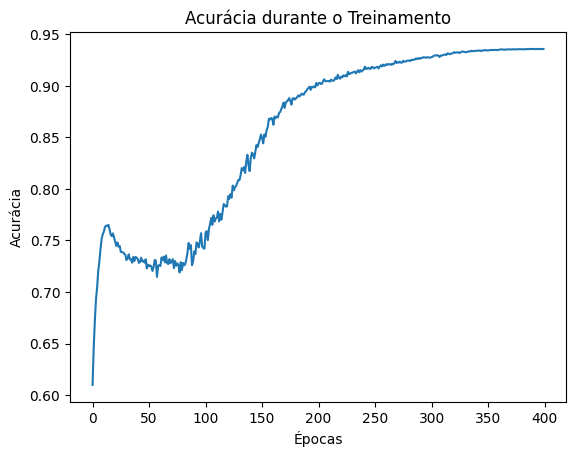

In [24]:
import matplotlib.pyplot as plt

# Lista para armazenar as acurácias
accuracies = []

failed = 1

while(failed):
    model_fn = DL_model
    optimizer = optim.SGD(model_fn.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

    for epoch in range(n_epochs):
        total_correct = 0
        total_samples = 0

        for imgs, img_labels in train_loader:  # imgs[64x1xWxH] (64 or 256)
            batch_size = imgs.shape[0]
            imgs_resized = imgs.view(batch_size, -1)  # Converte imgs para [64x3072]

            outputs = model_fn(imgs_resized)
            loss = loss_fn(outputs, img_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Cálculo da acurácia
            predicted = (outputs > 0.5).float()  # Aplicando um limiar para prever a classe
            total_correct += (predicted == img_labels).sum().item()  # Contando acertos
            total_samples += batch_size  # Total de amostras

        # Cálculo da acurácia
        accuracy = total_correct / total_samples
        accuracies.append(accuracy)  # Armazenando a acurácia

        print("Epoch: ", epoch)
        print("Learning Rate: ", scheduler.get_last_lr())
        print("Loss: ", loss.item())
        print("Accuracy: ", accuracy)

        scheduler.step()

    if loss.item() < 0.325:
        failed = 0
        print("Model complete.")
        print("Final Loss: ", loss.item())
    else:
        print("Model failed.")
        print("Final Loss: ", loss.item())

# Plotar a acurácia após o treinamento
plt.plot(accuracies)
plt.title("Acurácia durante o Treinamento")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.show()

In [56]:
img_dir_men = "Dataset/Test/Male"
img_dir_women = "Dataset/Test/Female"

In [57]:
filenames_men = [os.path.join(img_dir_men, file) for file in os.listdir(img_dir_men)[:10]]
filenames_women = [os.path.join(img_dir_women, file) for file in os.listdir(img_dir_women)[:10]]
filenames = filenames_men + filenames_women

In [58]:
grey_images = [Image.open(file).convert('L').resize((128, 128)) for file in filenames]
transform = transforms.Compose([transforms.PILToTensor()])
images = [transform(img) for img in grey_images]

In [59]:
labels_men = [0 for _ in filenames_men]
labels_women = [1 for _ in filenames_women]
labels = labels_men + labels_women
labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

In [60]:
total_correct = 0
total_samples = 0

# Test the model on the prepared images
with torch.no_grad():  # No need to track gradients during testing
    for i, img in enumerate(images):
        img = img.view(1, -1).float()  # Flatten the image to match the input size of the model (1x3072)
        output = model_fn(img)
        predicted = (output > 0.5).float()  # Apply threshold to get the class
        correct = (predicted == labels[i]).item()
        print(f"Image {i+1}: Predicted = {predicted.item()}, Actual = {labels[i].item()}")

Image 1: Predicted = 1.0, Actual = 0.0
Image 2: Predicted = 0.0, Actual = 0.0
Image 3: Predicted = 0.0, Actual = 0.0
Image 4: Predicted = 0.0, Actual = 0.0
Image 5: Predicted = 0.0, Actual = 0.0
Image 6: Predicted = 0.0, Actual = 0.0
Image 7: Predicted = 0.0, Actual = 0.0
Image 8: Predicted = 0.0, Actual = 0.0
Image 9: Predicted = 0.0, Actual = 0.0
Image 10: Predicted = 0.0, Actual = 0.0
Image 11: Predicted = 1.0, Actual = 1.0
Image 12: Predicted = 1.0, Actual = 1.0
Image 13: Predicted = 1.0, Actual = 1.0
Image 14: Predicted = 1.0, Actual = 1.0
Image 15: Predicted = 1.0, Actual = 1.0
Image 16: Predicted = 1.0, Actual = 1.0
Image 17: Predicted = 1.0, Actual = 1.0
Image 18: Predicted = 1.0, Actual = 1.0
Image 19: Predicted = 1.0, Actual = 1.0
Image 20: Predicted = 1.0, Actual = 1.0


In [ ]:
with torch.no_grad():
    for i, img in enumerate(images):
        # A imagem precisa ser achatada para o formato esperado pelo modelo (1x3072)
        img_flat = img.view(1, -1).float()

        # Fazer a predição com o modelo
        output = model_fn(img_flat)
        predicted = (output > 0.5).float().item()  # Aplicar o limiar para obter a classe

        # Obter a classe verdadeira
        actual = labels[i].item()

        # Mostrar a imagem
        plt.figure()
        plt.imshow(grey_images[i], cmap='gray')
        plt.title(f"Predicted: {'Woman' if predicted == 1 else 'Man'} | Actual: {'Woman' if actual == 1 else 'Man'}")
        plt.axis('off')
        plt.show()

In [63]:
torch.save(DL_model.state_dict(), 'mlp_model.pth')

## Check Accuracy:

In [21]:
print("MNIST Dataset Training with 3HDL Model:")

l_pred = []
names = ["female", "male"]

with torch.no_grad():
    for imgs, img_labels in test_loader:
        batch_size  = imgs.shape[0]
        imgs_resized = imgs.view(batch_size, -1)
        
        outputs     = model_fn(imgs_resized)
        
        pred        = (outputs>0.5).float()
        
        l_pred.append(pred)
    
    l_pred = torch.cat(l_pred)
    
    print_stats_percentage_train_test("3HDL", test_y_ds.cpu(), l_pred.cpu())
    
    print(classification_report(test_y_ds.cpu(), l_pred.cpu(), target_names=names))

MNIST Dataset Training with 3HDL Model:
Algorithm:  3HDL
Accuracy: 0.96
Precision: 0.957
Recall: 0.957
F1-measure: 0.957
confusion matrix
[[350  17]
 [ 12 291]]
              precision    recall  f1-score   support

      female       0.97      0.95      0.96       367
        male       0.94      0.96      0.95       303

    accuracy                           0.96       670
   macro avg       0.96      0.96      0.96       670
weighted avg       0.96      0.96      0.96       670

